In [13]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F 

In [15]:
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

100%|██████████| 9912422/9912422 [04:57<00:00, 33312.27it/s]


Extracting C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 215382.98it/s]


Extracting C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:49<00:00, 33070.45it/s]


Extracting C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 824020.45it/s]

Extracting C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\nicka/.pytorch/MNIST_data/MNIST\raw



In [16]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

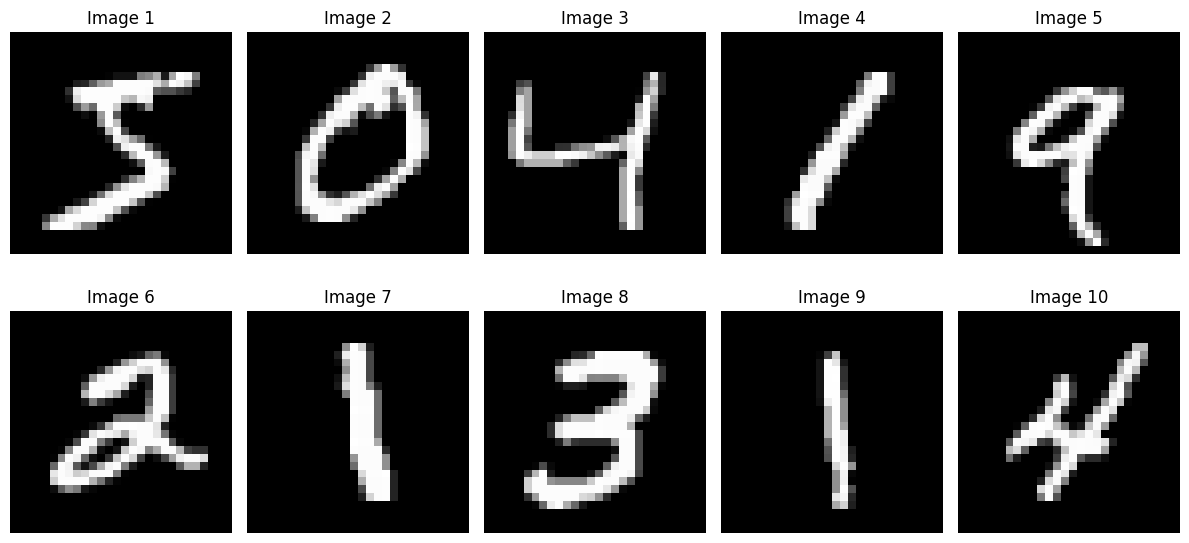

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy()

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    img = np.squeeze(images[i])
    ax.imshow(img, cmap='gray')
    ax.set_title('Image {}'.format(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [26]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Initialize an empty list to store the training losses
train_losses = []

# Set the number of epochs
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    # Calculate the average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Print the average training loss for the epoch
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

# Plot the training loss as a function of epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

# Make a deeper model to get better results #

In [38]:
class DeepConvAutoencoder(nn.Module):
    def __init__(self):
        super(DeepConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))  # output layer with sigmoid activation
                
        return x

# Initialize the deep convolutional autoencoder
deep_autoencoder = DeepConvAutoencoder()
print(deep_autoencoder)


DeepConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


# Train the model and plot the training loss curve #


Epoch: 1 	Training Loss: 0.025745
Epoch: 2 	Training Loss: 0.008560
Epoch: 3 	Training Loss: 0.007186
Epoch: 4 	Training Loss: 0.006548
Epoch: 5 	Training Loss: 0.006180
Epoch: 6 	Training Loss: 0.005935
Epoch: 7 	Training Loss: 0.005762
Epoch: 8 	Training Loss: 0.005632
Epoch: 9 	Training Loss: 0.005524
Epoch: 10 	Training Loss: 0.005439
Epoch: 11 	Training Loss: 0.005367
Epoch: 12 	Training Loss: 0.005306
Epoch: 13 	Training Loss: 0.005251
Epoch: 14 	Training Loss: 0.005205
Epoch: 15 	Training Loss: 0.005165
Epoch: 16 	Training Loss: 0.005130
Epoch: 17 	Training Loss: 0.005097
Epoch: 18 	Training Loss: 0.005068
Epoch: 19 	Training Loss: 0.005043
Epoch: 20 	Training Loss: 0.005019
Epoch: 21 	Training Loss: 0.004997
Epoch: 22 	Training Loss: 0.004976
Epoch: 23 	Training Loss: 0.004958
Epoch: 24 	Training Loss: 0.004940
Epoch: 25 	Training Loss: 0.004923
Epoch: 26 	Training Loss: 0.004907
Epoch: 27 	Training Loss: 0.004892
Epoch: 28 	Training Loss: 0.004877
Epoch: 29 	Training Loss: 0.0

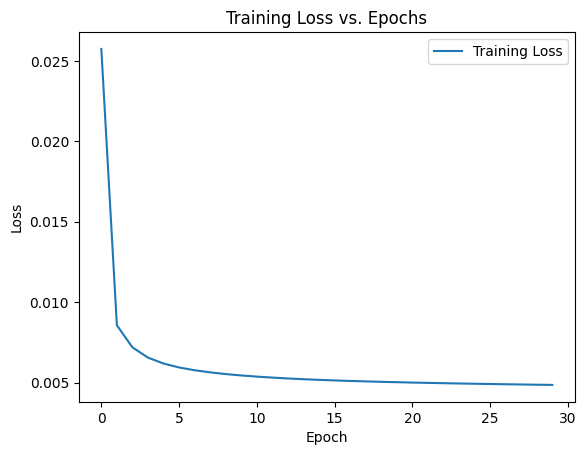

In [42]:
# Initialize your deep autoencoder model
deep_autoencoder = DeepConvAutoencoder()

# Specify the loss function
criterion = nn.MSELoss()

# Specify the optimizer
optimizer = torch.optim.Adam(deep_autoencoder.parameters(), lr=0.001)

# Initialize an empty list to store the training losses
train_losses = []

# Set the number of epochs
n_epochs = 30

# Training loop
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    # Train the model
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = deep_autoencoder(images)
        
        # Resize outputs to match the input size (28x28)
        outputs_resized = F.interpolate(outputs, size=(28, 28), mode='bilinear', align_corners=False)
        
        loss = criterion(outputs_resized, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    # Calculate the average training loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Print the average training loss for the epoch
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

# Plot the training loss as a function of epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

See some results


In [1]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# get sample outputs
outputs = deep_autoencoder(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
outputs_resized = F.interpolate(outputs, size=(28, 28), mode='bilinear', align_corners=False)
# use detach when it's an output that requires_grad
output = outputs_resized.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

NameError: name 'test_loader' is not defined